# Import modules

We probably need all the same stuff, plus matplotlib. I don't know this for sure, but I think it is true because I was lazy and used pickle instead of coming up with a data structure.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import itertools
from copy import deepcopy,copy
import numpy as np
import multiprocessing as mp
import pickle
import glob
import pandas as pd

##Fwdpy and libsequence
import fwdpy11 as fp11 #fwdpy11 
from fwdpy11.model_params import SlocusParams
import fwdpy11.wright_fisher as wf
import fwdpy11.sampling as fps
import libsequence.polytable as polyt
from libsequence.summstats import PolySIM

#My stuff
import clonal  #This is my fwdpy11 extension module for clonal evolution
import RecordStats # My recorder class



# Read in pickled data
Using the main evolve.py script, I simulated 30 replicates with the test parameters.

In [2]:
files=glob.glob('data/disc_recessive/disc_recessive_clonal_grape*.pkl')
files[0]

'data/disc_recessive/disc_recessive_clonal_grape.318.pkl'

In [3]:
pkl_data = [pickle.load(open(i,'rb')) for i in files]


In [4]:
generations = pkl_data[0]['ancestral'].generation + pkl_data[0]['const_outcross'].generation
#const_generation = ancestral_generation + pkl_data[0]['const_outcross'].generation
#non_eq_generation = ancestral_generation + pkl_data[0]['bottle_outcross'].generation

ancestral_N = pkl_data[0]['ancestral'].N
const_N = ancestral_N +  pkl_data[0]['const_outcross'].N
bottle_N = ancestral_N + pkl_data[0]['bottle_outcross'].N


In [5]:
deltaN = len(const_N) - len(ancestral_N)

In [6]:
def scale_time(gen,maxgen,N):
    st = [(i - maxgen)/(2.0*N) for i in gen]
    return(st)


In [7]:
scaled_time = scale_time(generations,
                               np.max(generations),
                               np.max(const_N))

# Population size history

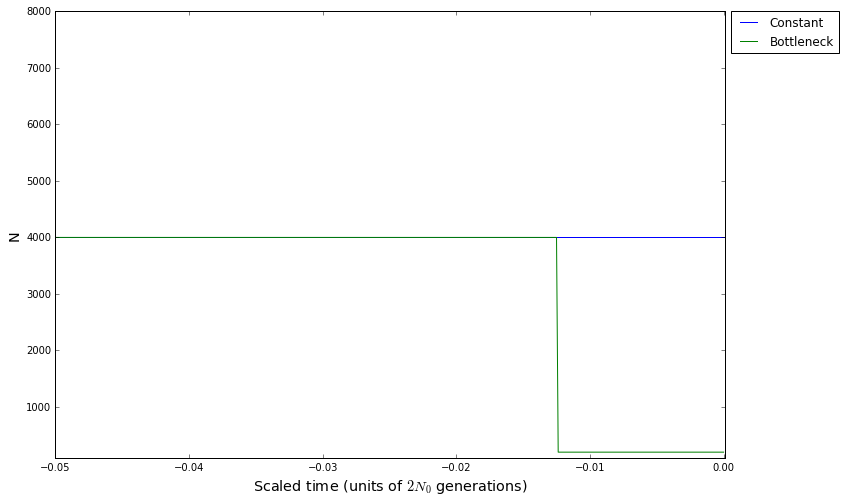

In [8]:
fig=plt.figure(figsize=(12,8))
line1, = plt.plot(scaled_time,const_N,label='Constant')
line2, = plt.plot(scaled_time,bottle_N,label='Bottleneck')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("N",size='x-large')
plt.xlim(-0.05,0.0001)
plt.ylim(np.min(bottle_N)/2,np.max(const_N)*2)
plt.legend( bbox_to_anchor=(1.17,1),borderaxespad=0.,loc=1)
plt.show()

# Tajima's D

In [39]:
ancestral_tajd = pd.DataFrame([i['ancestral'].total_tajd for i in pkl_data]).mean()
ancestral_tajd_var = pd.DataFrame([i['ancestral'].total_tajd for i in pkl_data]).var()

ancestral_tajd_upper = pd.DataFrame([i['ancestral'].total_tajd for i in pkl_data]).quantile(0.75)
ancestral_tajd_lower = pd.DataFrame([i['ancestral'].total_tajd for i in pkl_data]).quantile(0.25)


const_outcross_tajd = ancestral_tajd.append(
    pd.DataFrame([i['const_outcross'].total_tajd for 
                  i in pkl_data]).mean())

const_outcross_tajd_var = ancestral_tajd_var.append(
    pd.DataFrame([i['const_outcross'].total_tajd for 
                  i in pkl_data]).var())


bottle_outcross_tajd = ancestral_tajd.append(
    pd.DataFrame([i['bottle_outcross'].total_tajd for 
                  i in pkl_data]).mean())

bottle_outcross_tajd_var = ancestral_tajd_var.append(
    pd.DataFrame([i['bottle_outcross'].total_tajd for 
                  i in pkl_data]).var())


const_clonal_tajd = ancestral_tajd.append(
    pd.DataFrame([i['const_clonal'].total_tajd for 
                  i in pkl_data]).mean())

const_clonal_tajd_var = ancestral_tajd_var.append(
    pd.DataFrame([i['const_clonal'].total_tajd for 
                  i in pkl_data]).var())

bottle_clonal_tajd = ancestral_tajd.append(
    pd.DataFrame([i['bottle_clonal'].total_tajd for 
                  i in pkl_data]).mean())

bottle_clonal_tajd_var = ancestral_tajd_var.append(
    pd.DataFrame([i['bottle_clonal'].total_tajd for 
                  i in pkl_data]).var())


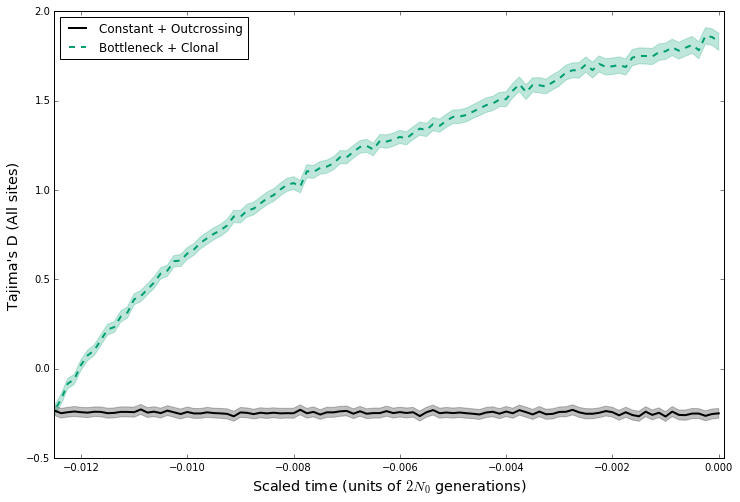

In [42]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_tajd,
                 label='Constant + Outcrossing',
                 color="#000000",lw=2)
plt.fill_between(scaled_time, 
                 const_outcross_tajd - np.sqrt(const_outcross_tajd_var/500), 
                 const_outcross_tajd + np.sqrt(const_outcross_tajd_var/500),
    alpha=0.25,edgecolor="#000000", facecolor='#000000')

#line2 = plt.plot(scaled_time,bottle_outcross_tajd,label='Bottleneck + Outcrossing',color="#E69F00")
#plt.fill_between(scaled_time, 
#                 bottle_outcross_tajd - np.sqrt(bottle_outcross_tajd_var/500), 
#                 bottle_outcross_tajd + np.sqrt(bottle_outcross_tajd_var/500),
#    alpha=0.25 ,facecolor='#E69F00')


#line3 = plt.plot(scaled_time,const_clonal_tajd,label='Constant + Clonal',color="#56B4E9")
#plt.fill_between(scaled_time, 
#                 const_clonal_tajd - np.sqrt(const_clonal_tajd_var/500), 
#                 const_clonal_tajd + np.sqrt(const_clonal_tajd_var/500),
#    alpha=0.25 ,facecolor='#E69F00')

line4 = plt.plot(scaled_time,bottle_clonal_tajd,
                 label='Bottleneck + Clonal',
                 color= "#009E73",
                lw=2,ls='dashed')
plt.fill_between(scaled_time, 
                 bottle_clonal_tajd - np.sqrt(bottle_clonal_tajd_var/500), 
                 bottle_clonal_tajd + np.sqrt(bottle_clonal_tajd_var/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')


plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Tajima's D (All sites)",size='x-large')
plt.xlim(-0.0125,0.0001)
plt.ylim(-0.5,2)
plt.legend(loc=0)# bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
fig.savefig('plots/sim_tajd_time_disc_recessive.pdf')
plt.show()

In [36]:
ancestral_tajd = pd.DataFrame([i['ancestral'].total_tajd[len(ancestral_N)-1] for i in pkl_data])

const_outcross_tajd =  pd.DataFrame([i['const_outcross'].total_tajd[deltaN-1] for 
                                     i in pkl_data])

bottle_outcross_tajd = pd.DataFrame([i['bottle_outcross'].total_tajd[deltaN-1] for 
                  i in pkl_data])

const_clonal_tajd = pd.DataFrame([i['const_clonal'].total_tajd[deltaN-1] for 
                  i in pkl_data])

bottle_clonal_tajd = pd.DataFrame([i['bottle_clonal'].total_tajd[deltaN-1] for 
                  i in pkl_data])

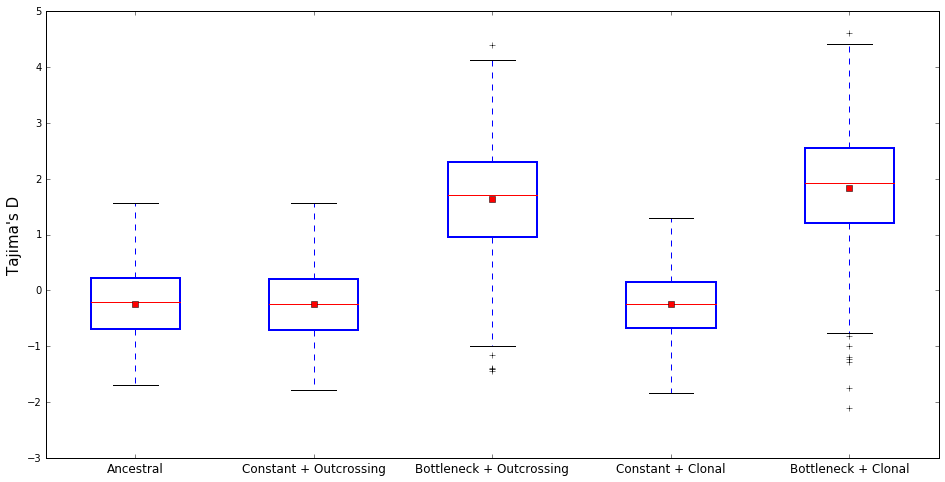

In [37]:
labels=['Ancestral',
       'Constant + Outcrossing',
       'Bottleneck + Outcrossing',
       'Constant + Clonal',
       'Bottleneck + Clonal']
fig=plt.figure(figsize=(16,8))
ax= fig.add_subplot(111)
bp = ax.boxplot([ancestral_tajd,
                const_outcross_tajd,
                bottle_outcross_tajd,
                const_clonal_tajd,
                bottle_clonal_tajd],
                labels=labels,
                showmeans=True,patch_artist=True)
for box in bp['boxes']:
    box.set(linewidth=2)
    #box.set( facecolor = '#1b9e77' )

#fig.boxplot(df,labels=labels,showmeans=True)
#ax.set_title("",fontsize=15)
ax.set_ylabel("Tajima's D",fontsize=15)

ax.set_xticklabels(labels,fontsize=12)
fig.savefig('plots/sim_tajd_box_disc_recessive.pdf')

# Neutral Heterozygosity

In [13]:
ancestral_pi = pd.DataFrame([i['ancestral'].neutral_pi for i in pkl_data]).mean()

const_outcross_pi = ancestral_pi.append(
    pd.DataFrame([i['const_outcross'].neutral_pi for 
                  i in pkl_data]).mean())

bottle_outcross_pi = ancestral_pi.append(
    pd.DataFrame([i['bottle_outcross'].neutral_pi for 
                  i in pkl_data]).mean())

const_clonal_pi = ancestral_pi.append(
    pd.DataFrame([i['const_clonal'].neutral_pi for 
                  i in pkl_data]).mean())

bottle_clonal_pi = ancestral_pi.append(
    pd.DataFrame([i['bottle_clonal'].neutral_pi for 
                  i in pkl_data]).mean())


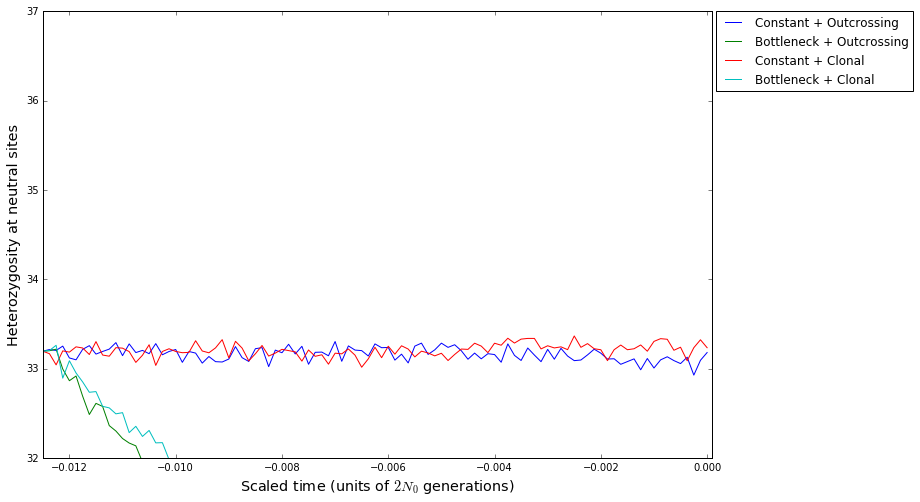

In [14]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_pi,label='Constant + Outcrossing')
line2 = plt.plot(scaled_time,bottle_outcross_pi,label='Bottleneck + Outcrossing')
line3 = plt.plot(scaled_time,const_clonal_pi,label='Constant + Clonal')
line4 = plt.plot(scaled_time,bottle_clonal_pi,label='Bottleneck + Clonal')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Heterozygosity at neutral sites",size='x-large')
plt.xlim(-0.0125,0.0001)
plt.ylim(32,37)
plt.legend( bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
plt.show()

# All sites heterozygosity

In [15]:
ancestral_pi = pd.DataFrame([i['ancestral'].total_pi for i in pkl_data]).mean()

const_outcross_pi = ancestral_pi.append(
    pd.DataFrame([i['const_outcross'].total_pi for 
                  i in pkl_data]).mean())

bottle_outcross_pi = ancestral_pi.append(
    pd.DataFrame([i['bottle_outcross'].total_pi for 
                  i in pkl_data]).mean())

const_clonal_pi = ancestral_pi.append(
    pd.DataFrame([i['const_clonal'].total_pi for 
                  i in pkl_data]).mean())

bottle_clonal_pi = ancestral_pi.append(
    pd.DataFrame([i['bottle_clonal'].total_pi for 
                  i in pkl_data]).mean())

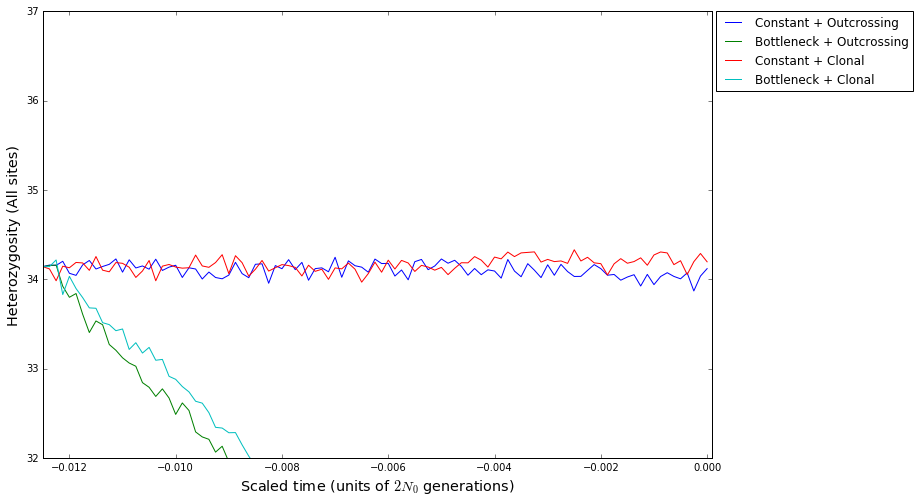

In [16]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_pi,label='Constant + Outcrossing')
line2 = plt.plot(scaled_time,bottle_outcross_pi,label='Bottleneck + Outcrossing')
line3 = plt.plot(scaled_time,const_clonal_pi,label='Constant + Clonal')
line4 = plt.plot(scaled_time,bottle_clonal_pi,label='Bottleneck + Clonal')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Heterozygosity (All sites)",size='x-large')
plt.xlim(-0.0125,0.0001)
plt.ylim(32,37)
plt.legend( bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
plt.show()

# Total deleterious mutations

In [17]:
def total_muts(recorder):
    total_muts = [i + 2*j for i,j in 
                     zip(recorder.mean_deleterious_per_diploid,
                    recorder.fixed_deleterious)]
    return(total_muts)

In [43]:
ancestral_muts = pd.DataFrame([total_muts(i['ancestral']) for i in pkl_data]).mean()
ancestral_muts_var = pd.DataFrame([total_muts(i['ancestral']) for i in pkl_data]).var()

const_outcross_muts = ancestral_muts.append(
    pd.DataFrame([total_muts(i['const_outcross']) for 
                  i in pkl_data]).mean())
const_outcross_muts_var = ancestral_muts_var.append(
    pd.DataFrame([total_muts(i['const_outcross']) for 
                  i in pkl_data]).var())

bottle_outcross_muts = ancestral_muts.append(
    pd.DataFrame([total_muts(i['bottle_outcross']) for 
                  i in pkl_data]).mean())
bottle_outcross_muts_var = ancestral_muts_var.append(
    pd.DataFrame([total_muts(i['bottle_outcross']) for 
                  i in pkl_data]).var())

const_clonal_muts = ancestral_muts.append(
    pd.DataFrame([total_muts(i['const_clonal']) for 
                  i in pkl_data]).mean())
const_clonal_muts_var = ancestral_muts_var.append(
    pd.DataFrame([total_muts(i['const_clonal']) for 
                  i in pkl_data]).var())


bottle_clonal_muts = ancestral_muts.append(
    pd.DataFrame([total_muts(i['bottle_clonal']) for 
                  i in pkl_data]).mean())
bottle_clonal_muts_var = ancestral_muts_var.append(
    pd.DataFrame([total_muts(i['bottle_clonal']) for 
                  i in pkl_data]).var())


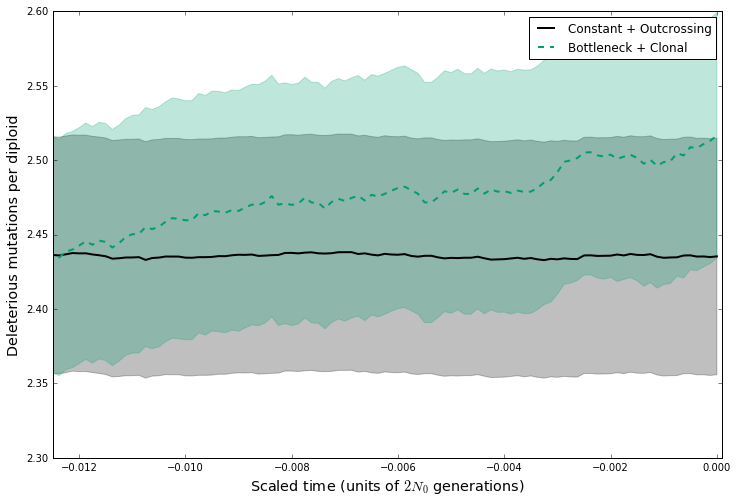

In [44]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_muts,
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
plt.fill_between(scaled_time, 
                 const_outcross_muts - np.sqrt(const_outcross_muts_var/500), 
                 const_outcross_muts + np.sqrt(const_outcross_muts_var/500),
    alpha=0.25,edgecolor="#000000", facecolor='#000000')

#line2 = plt.plot(scaled_time,bottle_outcross_muts,label='Bottleneck + Outcrossing')
#line3 = plt.plot(scaled_time,const_clonal_muts,label='Constant + Clonal')
line4 = plt.plot(scaled_time,bottle_clonal_muts,
                 label='Bottleneck + Clonal',
                 color='#009E73',
                lw=2,
                ls='dashed')
plt.fill_between(scaled_time, 
                 bottle_clonal_muts - np.sqrt(bottle_clonal_muts_var/500), 
                 bottle_clonal_muts + np.sqrt(bottle_clonal_muts_var/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Deleterious mutations per diploid",size='x-large')
plt.xlim(-0.0125,0.0001)
plt.ylim(2.3,2.6)
plt.legend(loc=0)
fig.savefig('plots/sim_muts_disc_recessive.pdf')
plt.show()

In [45]:
cd = pd.DataFrame([total_muts(i['ancestral'])[len(ancestral_N)-1] for i in pkl_data])

const_outcross_muts = pd.DataFrame([total_muts(i['const_outcross'])[deltaN-1] for 
                  i in pkl_data])

bottle_outcross_muts =pd.DataFrame([total_muts(i['bottle_outcross'])[deltaN-1] for 
                  i in pkl_data])

const_clonal_muts = pd.DataFrame([total_muts(i['const_clonal'])[deltaN-1] for 
                  i in pkl_data])

bottle_clonal_muts = pd.DataFrame([total_muts(i['bottle_clonal'])[deltaN-1] for 
                  i in pkl_data])

df = pd.concat([ancestral_muts,
                const_outcross_muts,
                bottle_outcross_muts,
                const_clonal_muts,
                bottle_clonal_muts],axis=1)

In [46]:
(bottle_clonal_muts.mean() - const_outcross_muts.mean())/(const_outcross_muts.mean())


0    0.033376
dtype: float64

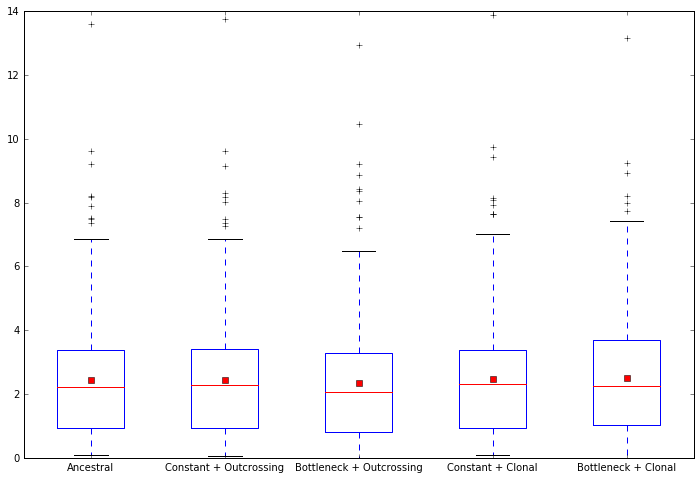

In [22]:
labels=['Ancestral',
       'Constant + Outcrossing',
       'Bottleneck + Outcrossing',
       'Constant + Clonal',
       'Bottleneck + Clonal']
fig=plt.figure(figsize=(12,8))
ax= fig.add_subplot(111)
bp = ax.boxplot([ancestral_muts,
                const_outcross_muts,
                bottle_outcross_muts,
                const_clonal_muts,
                bottle_clonal_muts],labels=labels,showmeans=True)
#fig.boxplot(df,labels=labels,showmeans=True)
#fig.set_title('Number of fixed deleterious mutations')
plt.show()

# Fixed deleterious mutations

In [23]:
ancestral_fixed = pd.DataFrame([i['ancestral'].fixed_deleterious for i in pkl_data]).mean()

const_outcross_fixed = ancestral_fixed.append(
    pd.DataFrame([i['const_outcross'].fixed_deleterious for 
                  i in pkl_data]).mean())

bottle_outcross_fixed = ancestral_fixed.append(
    pd.DataFrame([i['bottle_outcross'].fixed_deleterious for 
                  i in pkl_data]).mean())

const_clonal_fixed = ancestral_fixed.append(
    pd.DataFrame([i['const_clonal'].fixed_deleterious for 
                  i in pkl_data]).mean())

bottle_clonal_fixed = ancestral_fixed.append(
    pd.DataFrame([i['bottle_clonal'].fixed_deleterious for 
                  i in pkl_data]).mean())

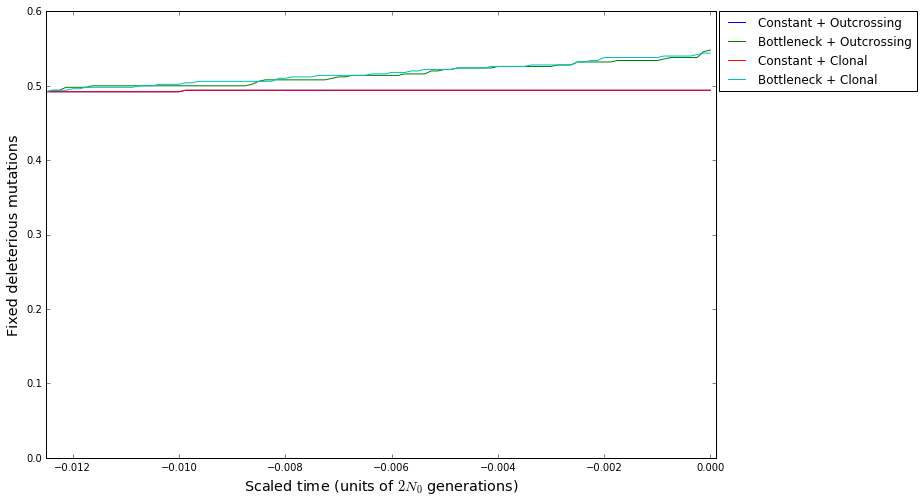

In [25]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_fixed,label='Constant + Outcrossing')
line2 = plt.plot(scaled_time,bottle_outcross_fixed,label='Bottleneck + Outcrossing')
line3 = plt.plot(scaled_time,const_clonal_fixed,label='Constant + Clonal')
line4 = plt.plot(scaled_time,bottle_clonal_fixed,label='Bottleneck + Clonal')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Fixed deleterious mutations",size='x-large')
plt.xlim(-0.0125,0.0001)
#plt.ylim(0.35,.4)
plt.legend( bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
plt.show()

In [26]:
ancestral_fixed = pd.DataFrame([i['ancestral'].fixed_deleterious[len(ancestral_N)-1] for i in pkl_data])

const_outcross_fixed = pd.DataFrame([i['const_outcross'].fixed_deleterious[deltaN-1] for 
                  i in pkl_data])

bottle_outcross_fixed =pd.DataFrame([i['bottle_outcross'].fixed_deleterious[deltaN-1] for 
                  i in pkl_data])

const_clonal_fixed = pd.DataFrame([i['const_clonal'].fixed_deleterious[deltaN-1] for 
                  i in pkl_data])

bottle_clonal_fixed = pd.DataFrame([i['bottle_clonal'].fixed_deleterious[deltaN-1] for 
                  i in pkl_data])

df = pd.concat([ancestral_fixed,
                const_outcross_fixed,
                bottle_outcross_fixed,
                const_clonal_fixed,
                bottle_clonal_fixed],axis=1)

In [81]:
df.mean()

0    0.356
0    0.360
0    0.370
0    0.356
0    0.366
dtype: float64

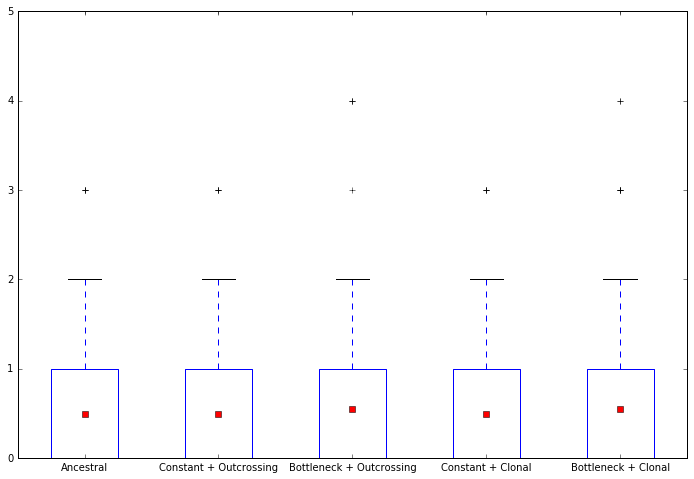

In [27]:
labels=['Ancestral',
       'Constant + Outcrossing',
       'Bottleneck + Outcrossing',
       'Constant + Clonal',
       'Bottleneck + Clonal']
fig=plt.figure(figsize=(12,8))
ax= fig.add_subplot(111)
bp = ax.boxplot([ancestral_fixed,
                const_outcross_fixed,
                bottle_outcross_fixed,
                const_clonal_fixed,
                bottle_clonal_fixed],labels=labels,showmeans=True)
#fig.boxplot(df,labels=labels,showmeans=True)
#fig.set_title('Number of fixed deleterious mutations')
plt.show()

# Fixed Load

In [28]:
ancestral_fload = pd.DataFrame([i['ancestral'].fixed_load for i in pkl_data]).mean()

const_outcross_fload = ancestral_fload.append(
    pd.DataFrame([i['const_outcross'].fixed_load for 
                  i in pkl_data]).mean())

bottle_outcross_fload = ancestral_fload.append(
    pd.DataFrame([i['bottle_outcross'].fixed_load for 
                  i in pkl_data]).mean())

const_clonal_fload = ancestral_fload.append(
    pd.DataFrame([i['const_clonal'].fixed_load for 
                  i in pkl_data]).mean())

bottle_clonal_fload = ancestral_fload.append(
    pd.DataFrame([i['bottle_clonal'].fixed_load for 
                  i in pkl_data]).mean())


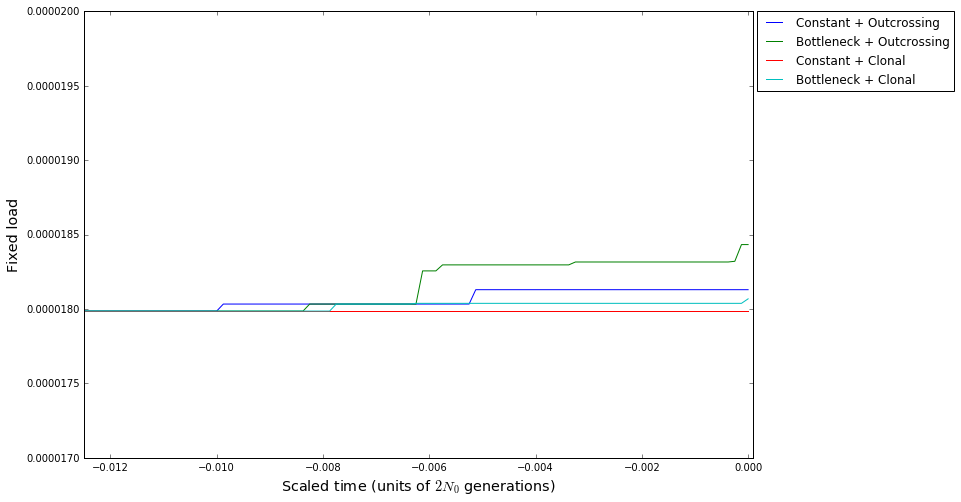

In [29]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_fload,label='Constant + Outcrossing')
line2 = plt.plot(scaled_time,bottle_outcross_fload,label='Bottleneck + Outcrossing')
line3 = plt.plot(scaled_time,const_clonal_fload,label='Constant + Clonal')
line4 = plt.plot(scaled_time,bottle_clonal_fload,label='Bottleneck + Clonal')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Fixed load",size='x-large')
plt.xlim(-0.0125,0.0001)
plt.ylim(0.000017,0.00002)
plt.legend( bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
plt.show()

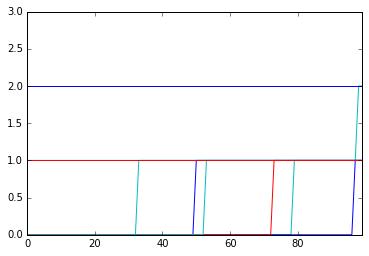

In [42]:
fig=plt.figure(figsize=(12,8))

df = pd.DataFrame([i['bottle_outcross'].fixed_deleterious for 
                  i in pkl_data])
df.transpose().plot(legend=None)

plt.show()

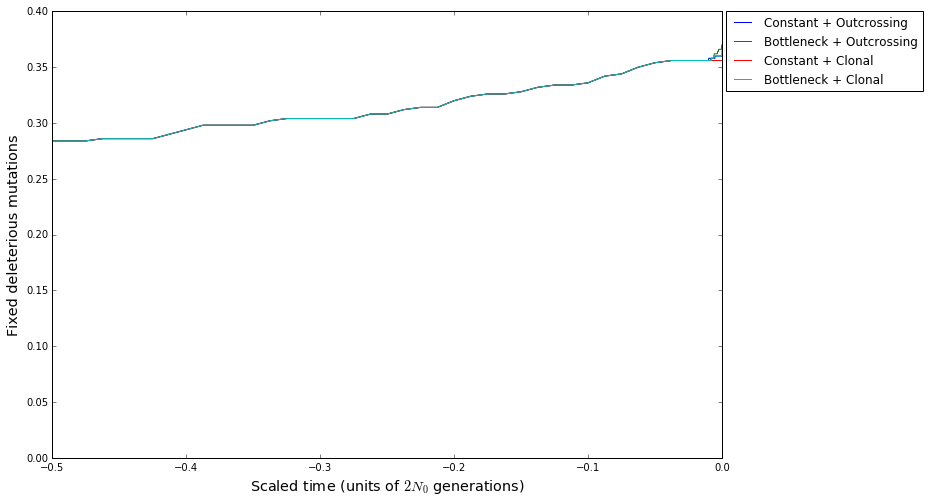

# Segregating Load

In [83]:
ancestral_sload = pd.DataFrame([i['ancestral'].segregating_load for i in pkl_data]).mean()

const_outcross_sload = ancestral_sload.append(
    pd.DataFrame([i['const_outcross'].segregating_load for 
                  i in pkl_data]).mean())

bottle_outcross_sload = ancestral_sload.append(
    pd.DataFrame([i['bottle_outcross'].segregating_load for 
                  i in pkl_data]).mean())

const_clonal_sload = ancestral_sload.append(
    pd.DataFrame([i['const_clonal'].segregating_load for 
                  i in pkl_data]).mean())

bottle_clonal_sload = ancestral_sload.append(
    pd.DataFrame([i['bottle_clonal'].segregating_load for 
                  i in pkl_data]).mean())


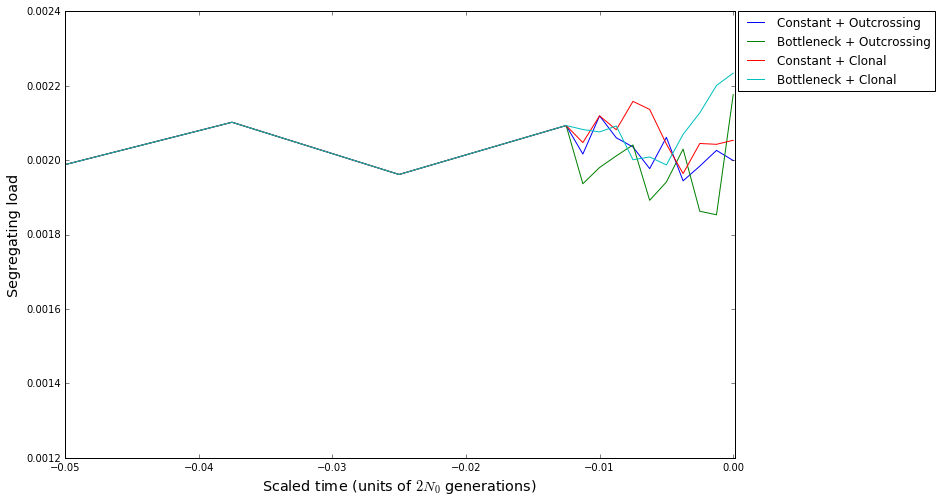

In [96]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_sload,label='Constant + Outcrossing')
line2 = plt.plot(scaled_time,bottle_outcross_sload,label='Bottleneck + Outcrossing')
line3 = plt.plot(scaled_time,const_clonal_sload,label='Constant + Clonal')
line4 = plt.plot(scaled_time,bottle_clonal_sload,label='Bottleneck + Clonal')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Segregating load",size='x-large')
plt.xlim(-0.05,0.0001)
plt.legend( bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
plt.show()

# Total load
For this I will caculate the true absolute fitness, including fixations

In [101]:
def total_load(recorder):
    tl = [1-(1-i)*(1-j) for i,j in zip(recorder.fixed_load,recorder.segregating_load)]
    return(tl)

In [103]:
ancestral_total_load = pd.DataFrame([total_load(i['ancestral']) for i in pkl_data]).mean()

const_outcross_total_load = ancestral_total_load.append(
    pd.DataFrame([total_load(i['const_outcross']) for 
                  i in pkl_data]).mean())

bottle_outcross_total_load= ancestral_total_load.append(
    pd.DataFrame([total_load(i['bottle_outcross']) for 
                  i in pkl_data]).mean())

const_clonal_total_load = ancestral_total_load.append(
    pd.DataFrame([total_load(i['const_clonal']) for 
                  i in pkl_data]).mean())

bottle_clonal_total_load= ancestral_total_load.append(
    pd.DataFrame([total_load(i['bottle_clonal']) for 
                  i in pkl_data]).mean())

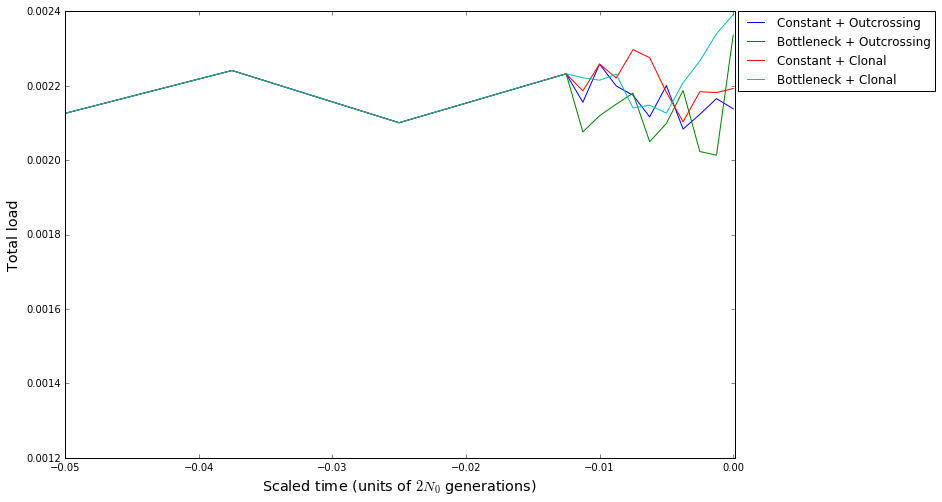

In [108]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_total_load,label='Constant + Outcrossing')
line2 = plt.plot(scaled_time,bottle_outcross_total_load,label='Bottleneck + Outcrossing')
line3 = plt.plot(scaled_time,const_clonal_total_load,label='Constant + Clonal')
line4 = plt.plot(scaled_time,bottle_clonal_total_load,label='Bottleneck + Clonal')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Total load",size='x-large')
plt.xlim(-0.05,0.0001)
plt.legend( bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
plt.show()

# Mean deleterious mutations per diploid

In [91]:
ancestral_muts = pd.DataFrame([i['ancestral'].mean_deleterious_per_diploid for i in pkl_data]).mean()

const_outcross_muts = ancestral_muts.append(
    pd.DataFrame([i['const_outcross'].mean_deleterious_per_diploid for 
                  i in pkl_data]).mean())

bottle_outcross_muts = ancestral_muts.append(
    pd.DataFrame([i['bottle_outcross'].mean_deleterious_per_diploid for 
                  i in pkl_data]).mean())

const_clonal_muts = ancestral_muts.append(
    pd.DataFrame([i['const_clonal'].mean_deleterious_per_diploid for 
                  i in pkl_data]).mean())

bottle_clonal_muts = ancestral_muts.append(
    pd.DataFrame([i['bottle_clonal'].mean_deleterious_per_diploid for 
                  i in pkl_data]).mean())

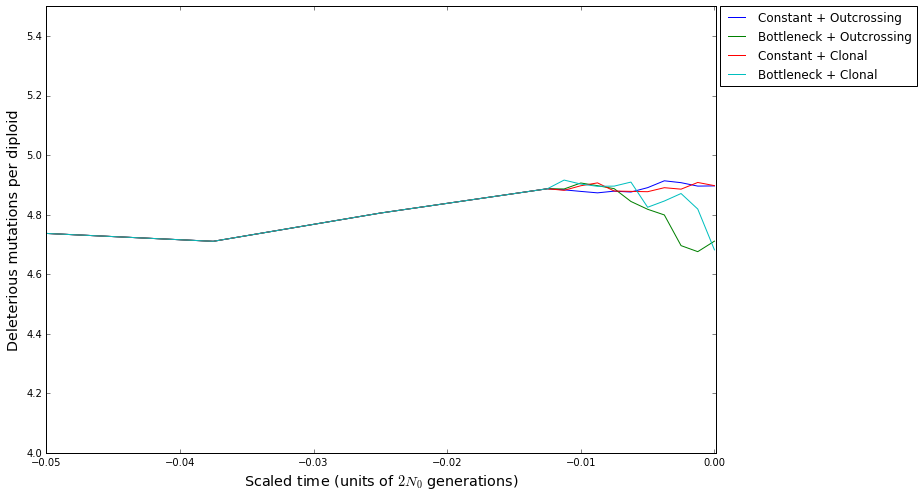

In [115]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(scaled_time,const_outcross_muts,label='Constant + Outcrossing')
line2 = plt.plot(scaled_time,bottle_outcross_muts,label='Bottleneck + Outcrossing')
line3 = plt.plot(scaled_time,const_clonal_muts,label='Constant + Clonal')
line4 = plt.plot(scaled_time,bottle_clonal_muts,label='Bottleneck + Clonal')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Deleterious mutations per diploid",size='x-large')
plt.xlim(-0.05,0.0001)
plt.ylim(4,5.5)

plt.legend( bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
plt.show()

# Cumulate deleterious allele frequency

In [48]:
const_outcross_freq = pd.DataFrame([i['const_outcross'].cumulative_deleterious_frequency for i in pkl_data]).mean()
bottle_outcross_freq = pd.DataFrame([[const_outcross_freq[gen_bottle]] + 
                                    i['bottle_outcross'].cumulative_deleterious_frequency for i in pkl_data]).mean()
const_clonal_freq = pd.DataFrame([[const_outcross_freq[gen_bottle]] + 
                                 i['const_clonal'].cumulative_deleterious_frequency for i in pkl_data]).mean()
bottle_clonal_freq = pd.DataFrame([[const_outcross_freq[gen_bottle]] + 
                                  i['bottle_clonal'].cumulative_deleterious_frequency for i in pkl_data]).mean()



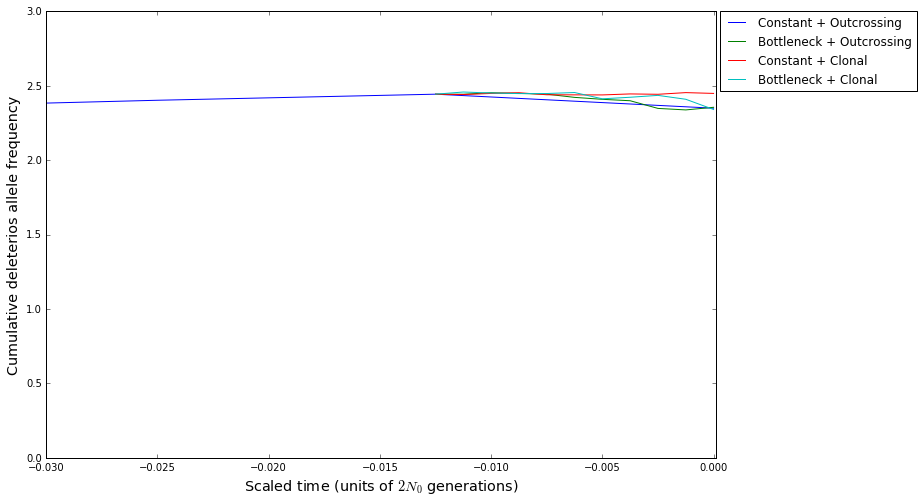

In [49]:
fig=plt.figure(figsize=(12,8))
line1 = plt.plot(st_const_outcross,const_outcross_freq,label='Constant + Outcrossing')
line2 = plt.plot(st_no_eq,bottle_outcross_freq,label='Bottleneck + Outcrossing')
line3 = plt.plot(st_no_eq,const_clonal_freq,label='Constant + Clonal')
line4 = plt.plot(st_no_eq,bottle_clonal_freq,label='Bottleneck + Clonal')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("Cumulative deleterios allele frequency",size='x-large')
plt.xlim(-0.03,0.0001)
plt.legend( bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1)
plt.show()